In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import yaml

from evasion_guidance.scripts.aircraft_model import AirCraftModel
from evasion_guidance.scripts.utils import generate_radar_config, visualiza_radar_config, generate_search_points
from evasion_guidance.scripts.cl_rrt import ClosedLoopRRTStar

%matplotlib widget
matplotlib.rcParams['figure.figsize'] = (10, 10)

### Radar configurations parameters ###

In [27]:
with open("../params/data_collection.yaml","r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)
    
map_range = config['env']['map_range']
radar_radius = config['env']['radar_radius']
min_num_radar = config['env']['min_num_radar']
max_num_radar = config['env']['max_num_radar']
V = config['planner']['V']
L1 = config['planner']['L1']
planning_delta_t = config['planner']['delta_t']
num_boundary_sample = config['planner']['serach_center_parameters']['num_boundary_sample']
bloat_radius = config['planner']['serach_center_parameters']['bloat_radius']
max_iter = config['planner']['max_iter']
random_sampling = config['data_collection']['random_sample']
search_radius= config['planner']['search_radius']
risk_interval= config['planner']['risk_buffer_length']
connect_circle_dist=config['planner']['connect_circle_dist']
min_dist_to_risk_radius_ratio=config['planner']['min_dist_to_risk_radius_ratio']
min_search_center_num=config['planner']['min_search_center_num']
max_collection_loop_num= config['data_collection']['collection_loop_num']

## Run CL-RRT on the power diagram ##

Chose the start point to be at the center

In [28]:
start = [map_range/2, map_range/2, np.deg2rad(0.0)]

An utility function to make sure we don't start close to any radar.

In [29]:
def verify_radar_config(radar_locs, start):
    init_loc = np.asarray([start[0], start[1]])
    for i in range(radar_locs.shape[0]):
        if np.linalg.norm(init_loc - radar_locs[i]) < 50.0:
            return False
    return True

Sample radar locations and visualize.

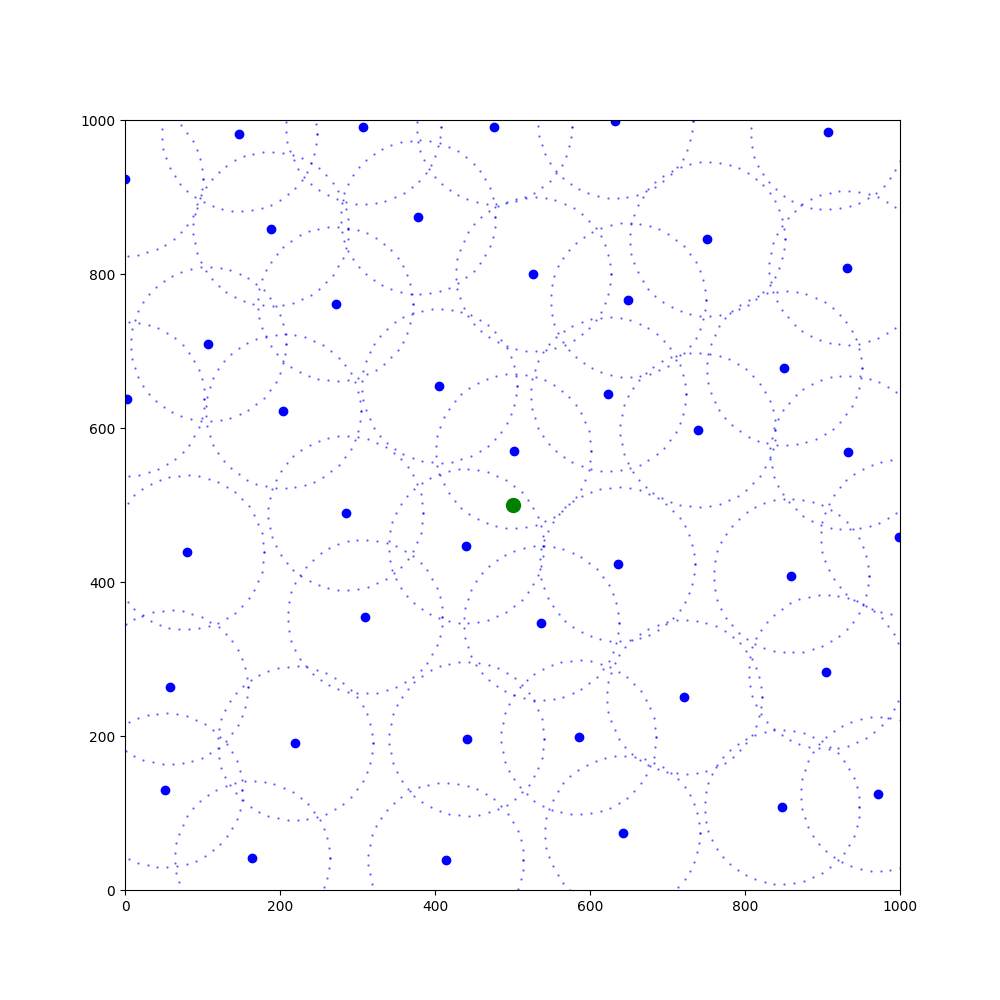

In [30]:
seperation_radius=np.random.uniform(config['env']['seperation_radius_bounds'][0], config['env']['seperation_radius_bounds'][1])
radar_minimal_separatin_dist=np.random.uniform(config['env']['radar_minimal_separatin_dist_bounds'][0], config['env']['radar_minimal_separatin_dist_bounds'][1])
radar_locs, radar_orientations = generate_radar_config(min_num_radar, max_num_radar, separation_radius=seperation_radius, radar_minimal_separatin_dist=radar_minimal_separatin_dist, map_range=map_range)
while not verify_radar_config(radar_locs, start):
    seperation_radius=np.random.uniform(config['env']['seperation_radius_bounds'][0], config['env']['seperation_radius_bounds'][1])
    radar_minimal_separatin_dist=np.random.uniform(config['env']['radar_minimal_separatin_dist_bounds'][0], config['env']['radar_minimal_separatin_dist_bounds'][1])
    radar_locs, radar_orientations = generate_radar_config(min_num_radar, max_num_radar, separation_radius=seperation_radius, radar_minimal_separatin_dist=radar_minimal_separatin_dist, map_range=map_range)
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radius=config['env']['radar_radius'], xlim=[0, config['env']['map_range']], ylim=[0, config['env']['map_range']])
ax.scatter(start[0], start[1], s=100, c='g')

Visualize the rrt sample distribution created from power Voronoi diagram generated from radar locations.

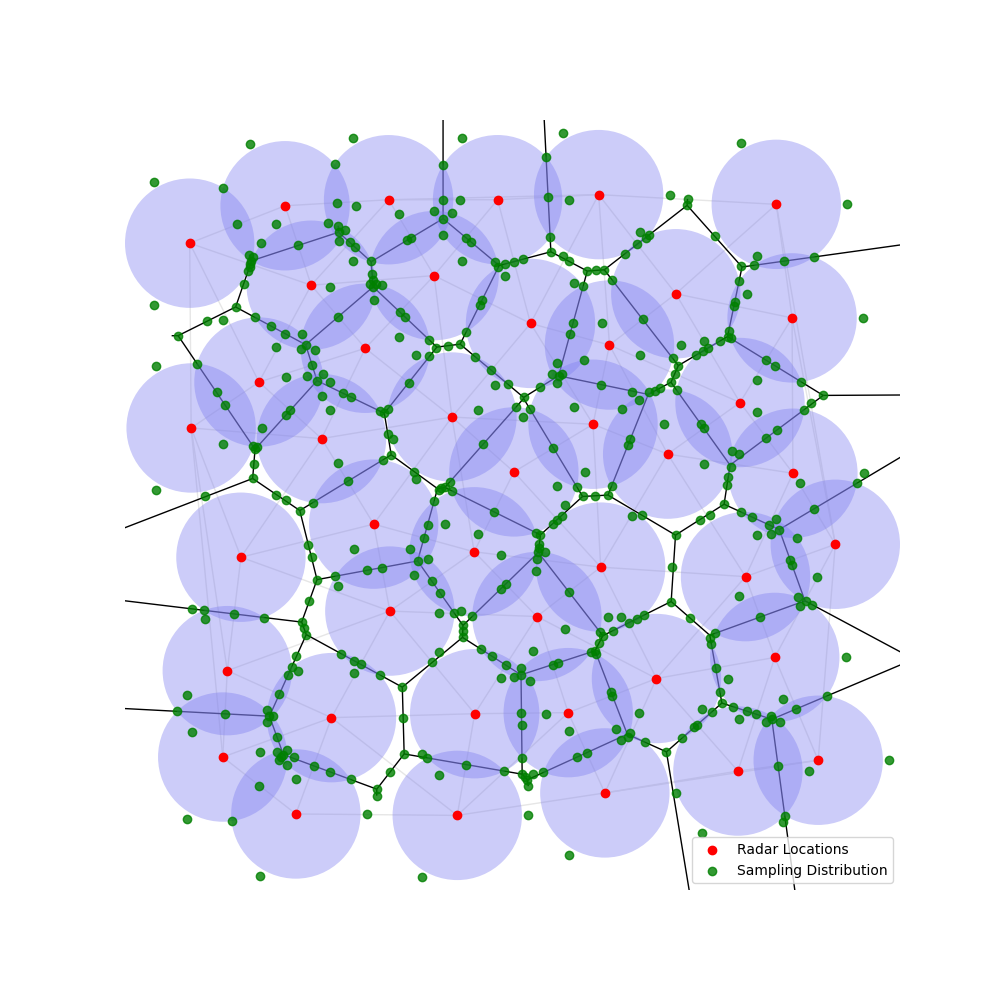

In [31]:
search_points_merged, search_centers_probabilities = generate_search_points(radar_locs, radar_radius, map_range, num_boundary_sample, bloat_radius)

In [32]:
def verify_goal(radar_locs, start, goal):
    if math.hypot(start[0] - goal[0], start[1] - goal[1]) < radar_radius:
        return False
    goal_pos = np.asarray([goal[0], goal[1]])
    for i in range(radar_locs.shape[0]):
        if np.linalg.norm(goal_pos - radar_locs[i]) < 60:
            return False
    return True

In [35]:
num_data = 0
max_num_data = config['data_collection']['collection_loop_num']
num_repeat_goal = config['data_collection']['repeat_each_goal']
runtime = []
while num_data < max_num_data:
    print("Number of data collected: ", num_data)
    gx=np.random.uniform(0, map_range)
    gy=np.random.uniform(0, map_range)
    gyaw=np.deg2rad(45.0) # doesn't matter
    goal = [gx, gy, gyaw]
    while not verify_goal(radar_locs, start, goal):
        gx=np.random.uniform(0, map_range)
        gy=np.random.uniform(0, map_range)
        goal = [gx, gy, gyaw]

    repeat_idx = 0
    while repeat_idx < 1:
        ###############################################################
        ###                 Perform RRT*                            ###
        ###############################################################
        ###### Uncomment the following two lines to visualize the planning process #####
        # visualize = True
        # fig, ax = plt.subplots()

        visualize = False
        fig, ax = None, None

        closed_loop_rrt_star = ClosedLoopRRTStar(start, goal, 
                                        speed=V, L1=L1, planning_delta_t=planning_delta_t,
                                        search_centers=search_points_merged,
                                        search_centers_probabilities=search_centers_probabilities, 
                                        search_radius= search_radius,
                                        radar_locations=radar_locs,
                                        risk_radius=radar_radius,
                                        risk_interval= risk_interval,
                                        max_iter=max_iter,
                                        expand_dist=3*radar_radius,
                                        connect_circle_dist=connect_circle_dist,
                                        min_dist_to_risk_radius_ratio=min_dist_to_risk_radius_ratio,
                                        tracking_tol=planning_delta_t*V,
                                        min_search_center_num=min_search_center_num,
                                        map_bound_x_min=0.0,
                                        map_bound_y_min=0.0,
                                        map_bound_x_max=map_range,
                                        map_bound_y_max=map_range,
                                        random_sample=random_sampling)
    
        try:
            time_start = time.time()
            paths, costs, node_sequences, input_histories, risk_histories = closed_loop_rrt_star.do_planning(ax, fig, animation=visualize)
            time_end = time.time()
            runtime.append(time_end - time_start)
        except:
            continue
        # time.sleep(0.1)
        # plt.close()

        if len(costs) > 0:
            idx=np.argmin(costs)

            node_sequence = node_sequences[idx]
            node_sequence_vis = []
            for node in node_sequence:
                node_sequence_vis.append([node.x, node.y])
            node_sequence_vis = np.asarray(node_sequence_vis)

            # fig, ax = plt.subplots()
            # visualiza_radar_config(radar_locs, radius=radar_radius, xlim=[0, map_range], ylim=[0, map_range])
            # ax.scatter(paths[idx][:, 0], paths[idx][:, 1], s=10, c='r')
            # ax.scatter(node_sequence_vis[:, 0], node_sequence_vis[:, 1], s=100, c='r')
            # for i in range(node_sequence_vis.shape[0]):
            #     ax.annotate(str(i), (node_sequence_vis[i, 0], node_sequence_vis[i, 1]))

            # ax.set_xlim(-200, 1.2*map_range)
            # ax.set_ylim(-200, 1.2*map_range)
            # time.sleep(0.1)
            # plt.close()

            # episode_dict = {'radar_locations': radar_locs, 
            #                 'start_state': np.asarray(start),
            #                 'goal_location': np.array([goal[0], goal[1]]),
            #                 'state_history': paths[idx],
            #                 'input_history': input_histories[idx],
            #                 'risk_history': risk_histories[idx],
            #                 'node_sequence': node_sequence_vis}
            # np.save(config['data_collection']['output_path'] + f'episode_{num_data}.npy', episode_dict)
            num_data += 1
        repeat_idx += 1



Number of data collected:  0


In [36]:
print(sum(runtime) / (len(runtime)))


0.6383647918701172


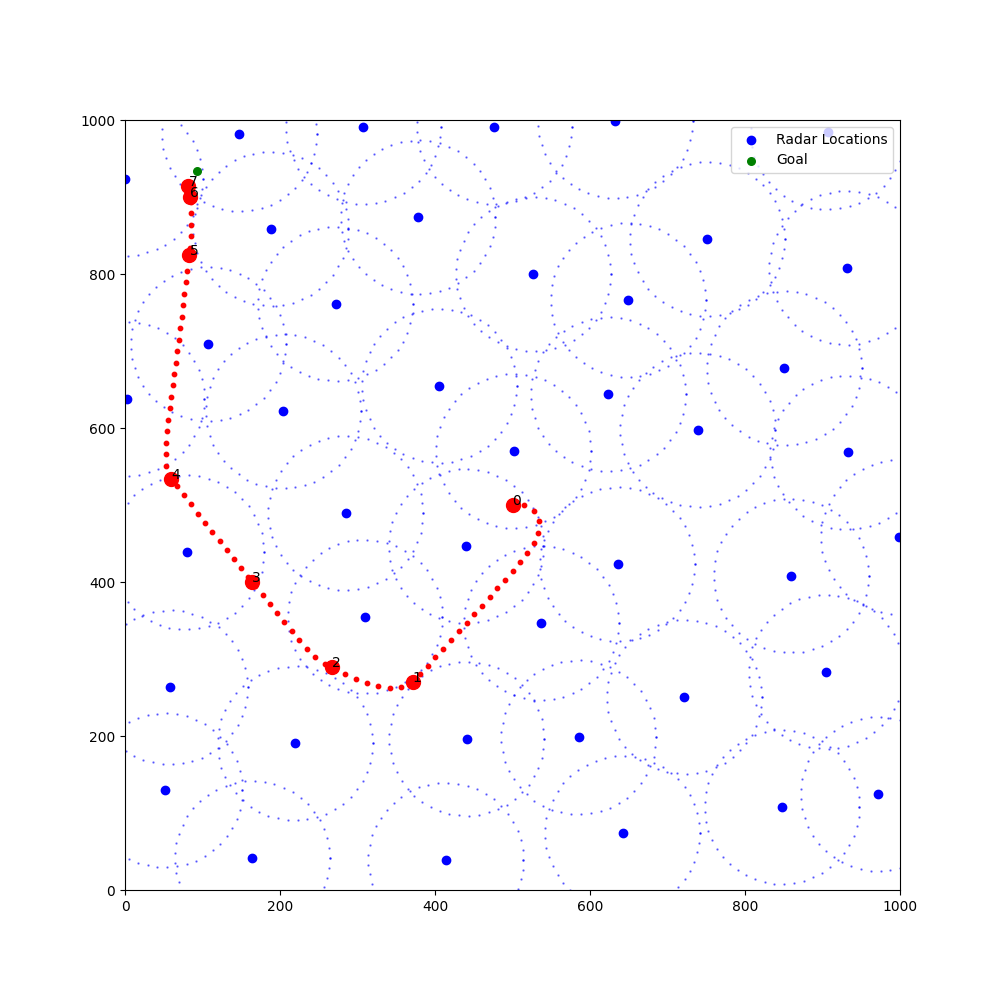

In [37]:
if len(costs) > 0:
    idx=np.argmin(costs)

    node_sequence = node_sequences[idx]
    node_sequence_vis = []
    for node in node_sequence:
        node_sequence_vis.append([node.x, node.y])
    node_sequence_vis = np.asarray(node_sequence_vis)

    fig, ax = plt.subplots()
    visualiza_radar_config(radar_locs, radius=radar_radius, xlim=[0, map_range], ylim=[0, map_range])
    ax.scatter(paths[idx][:, 0], paths[idx][:, 1], s=10, c='r')
    ax.scatter(node_sequence_vis[:, 0], node_sequence_vis[:, 1], s=100, c='r')
    for i in range(node_sequence_vis.shape[0]):
        ax.annotate(str(i), (node_sequence_vis[i, 0], node_sequence_vis[i, 1]))
    

    ax.scatter(goal[0], goal[1], s=30, c='g', label="Goal")
    # ax.set_xlim(-200, 1.2*map_range)
    # ax.set_ylim(-200, 1.2*map_range)
    ax.legend()

Track the planned path. Visualize the tracked path and the planned path.

In [38]:
aircraft_model = AirCraftModel(config['planner']['V'], config['planner']['delta_t'], config['planner']['L1'])
state_cur = start
path_tracked = [state_cur]
for i in range(len(input_histories[idx])):
    state_cur = aircraft_model.f_discrete(state_cur, input_histories[idx][i])
    path_tracked.append(state_cur)
path_tracked = np.asarray(path_tracked)

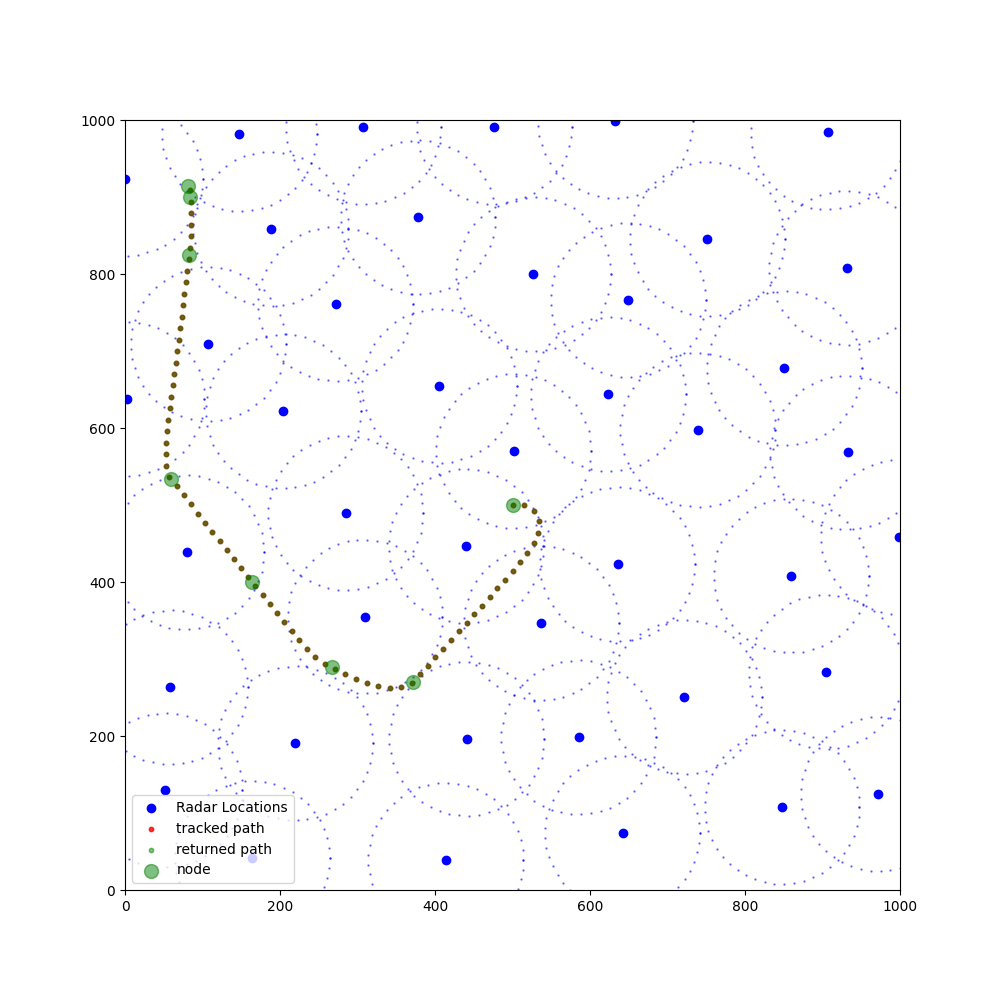

In [39]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radius=config['env']['radar_radius'], xlim=[0, config['env']['map_range']], ylim=[0, config['env']['map_range']])

ax.scatter(path_tracked[:, 0], path_tracked[:, 1], s=10, c='r', alpha=0.8, label='tracked path')
ax.scatter(paths[idx][:, 0], paths[idx][:, 1], s=10, c='g', alpha=0.5, label='returned path')
ax.scatter(node_sequence_vis[:, 0], node_sequence_vis[:, 1], s=100, c='g', alpha=0.5, label='node')
ax.set_xlim(0.0, config['env']['map_range'])
ax.set_ylim(0.0, config['env']['map_range'])
ax.legend()
plt.show()